# The Challenge : Predicting Telecom Customer Churn

A major telecom provider is experiencing significant customer churn (customers leaving their service). Your task is to build and evaluate a machine learning model that can predict which customers are likely to churn based on their account information and usage patterns.Identifying these customers proactively allows the company to offer targeted incentives to retain them.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

## Task 1 : Exploratory Data Analysis (EDA) and Initial Cleaning

### 1.1. Load & Inspect

In [2]:
df = pd.read_csv('telecom_churn.csv')
df

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,InternetService,MonthlyCharges,TotalCharges,Churn,Timestamp
0,CUST000001,Male,0.0,Yes,Yes,26.0,Yes,Fiber optic,70.32,NaN,No,2021-10-26
1,CUST000002,Female,0.0,No,No,NaN,Yes,Fiber optic,47.88,2161.36,Yes,2022-04-03
2,CUST000003,Male,0.0,No,Yes,NaN,Yes,NaN,99.91,4224.95,Yes,2021-05-03
3,CUST000004,Male,NaN,No,No,44.0,Yes,DSL,29.44,1340.09,No,2021-08-18
4,CUST000005,NaN,0.0,No,Yes,29.0,NaN,Fiber optic,78.82,2280.05,No,2022-02-17
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,CUST099996,Male,0.0,No,Yes,53.0,Yes,NaN,26.52,NaN,No,2021-12-09
99996,CUST099997,NaN,0.0,Yes,No,61.0,Yes,Fiber optic,NaN,3534.35,No,2020-12-09
99997,CUST099998,NaN,0.0,No,No,41.0,NaN,NaN,NaN,4739.0,No,2021-09-08
99998,CUST099999,NaN,NaN,Yes,Yes,9.0,Yes,NaN,57.20,526.29,Yes,2021-02-11


### 1.2. Initial Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerID       100000 non-null  object 
 1   Gender           81787 non-null   object 
 2   SeniorCitizen    81861 non-null   float64
 3   Partner          81994 non-null   object 
 4   Dependents       82003 non-null   object 
 5   Tenure           82001 non-null   float64
 6   PhoneService     82096 non-null   object 
 7   InternetService  81579 non-null   object 
 8   MonthlyCharges   81904 non-null   float64
 9   TotalCharges     80257 non-null   object 
 10  Churn            100000 non-null  object 
 11  Timestamp        81757 non-null   object 
dtypes: float64(3), object(9)
memory usage: 9.2+ MB


Column 'TotalCharges' is of object type which should be converted to numeric type.

In [4]:
df.TotalCharges.apply(type).value_counts()

TotalCharges
<class 'str'>      80257
<class 'float'>    19743
Name: count, dtype: int64

Column 'TotalCharges' consists of both string & float data types.

In [5]:
for i in df.TotalCharges:
    if type(i)!=float:
        if i.isnumeric==False:
            print(i)

No output shows 'TotalCharges' consists of either 'float' values or numbers as 'string'. So, we will simply convert all values to float in this column.

In [6]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') # errors='coerce': If a value cannot be converted, it becomes NaN
df.TotalCharges.apply(type).value_counts()

TotalCharges
<class 'float'>    100000
Name: count, dtype: int64

In [7]:
df.isnull().sum()

CustomerID             0
Gender             18213
SeniorCitizen      18139
Partner            18006
Dependents         17997
Tenure             17999
PhoneService       17904
InternetService    18421
MonthlyCharges     18096
TotalCharges       20591
Churn                  0
Timestamp          18243
dtype: int64

Except columns 'CustomerID' & 'Churn', almost 1/5th of all other columns are filled with missing values. 

### 1.3. Data Visualization

#### 1.3.1 Visualizations for Numeric Features vs Churn

In [8]:
num_cols = list(df.select_dtypes(include='number').columns) # selecting numeric features
num_cols

['SeniorCitizen', 'Tenure', 'MonthlyCharges', 'TotalCharges']

In [9]:
for col in num_cols:
    print(col, df[col].nunique())

SeniorCitizen 2
Tenure 73
MonthlyCharges 10199
TotalCharges 74219


'SeniorCitizen' is a binary categorical column as has only 2 unique values. So, we will remove it from numerical columns 

In [10]:
num_cols.remove('SeniorCitizen')
num_cols

['Tenure', 'MonthlyCharges', 'TotalCharges']

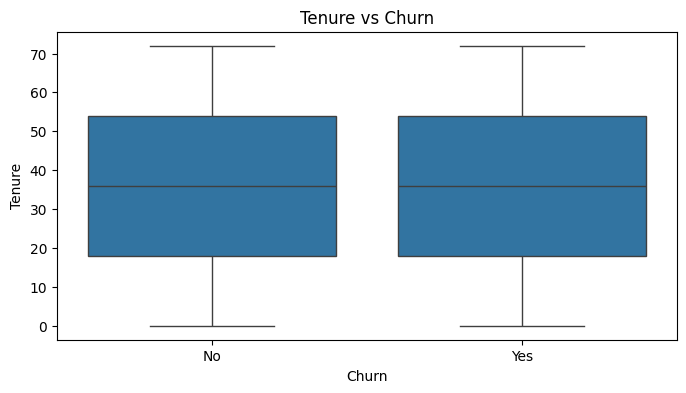

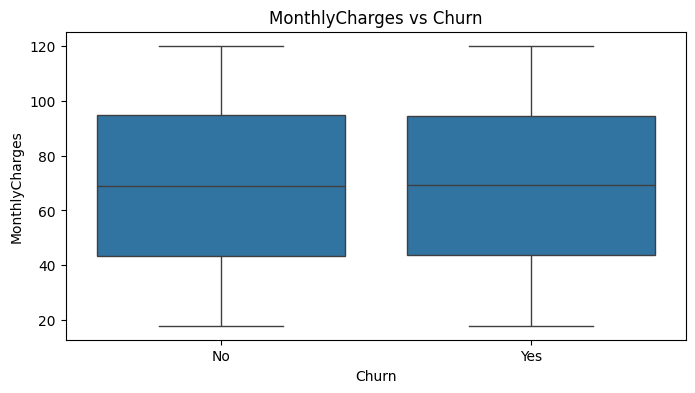

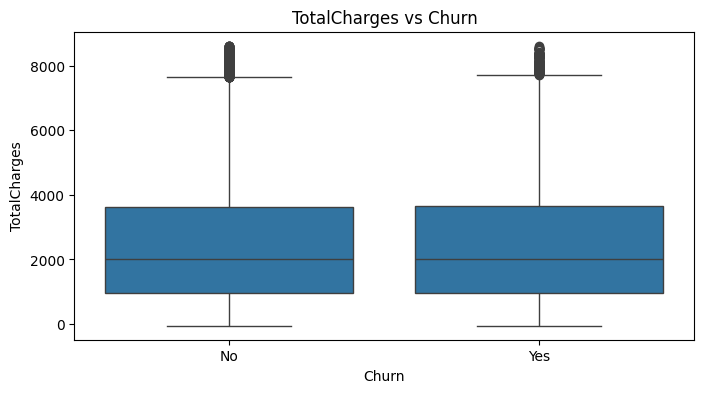

In [11]:
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(col +' vs Churn')
    plt.show()

- 1st & 2nd boxplots do not have outliers
- 3rd boxplot - 'TotalCharges vs Churn', has many outliers

#### 1.3.2. Visualizations for Categorical Features vs Churn

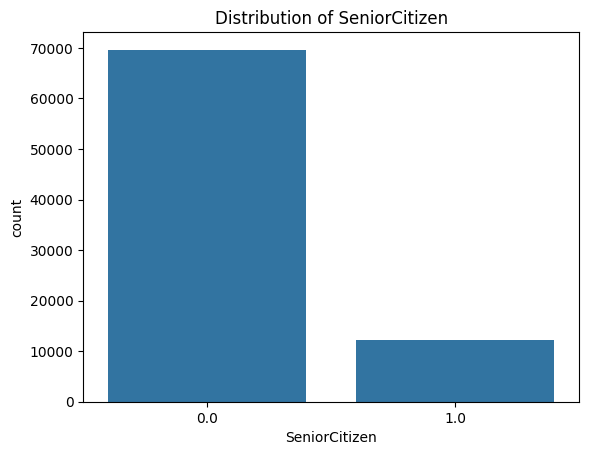

In [12]:
sns.countplot(x='SeniorCitizen', data=df)
plt.title('Distribution of SeniorCitizen')
plt.show()

Above Count plot tells that only 1/8th of the customers are Senior Citizens.

In [13]:
cat_cols = list(df.select_dtypes(include='object').columns) # selecting categorical features
cat_cols

['CustomerID',
 'Gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'InternetService',
 'Churn',
 'Timestamp']

In [14]:
for col in cat_cols:
    print(col, df[col].nunique())

CustomerID 100000
Gender 2
Partner 2
Dependents 2
PhoneService 2
InternetService 3
Churn 2
Timestamp 1095


'CustomerID' is all unique & 'Timestamp' has many unique values. So we won't consider them for visualization as that would result into many sub-categories.

In [15]:
cat_cols.remove('CustomerID')
cat_cols.remove('Timestamp')
cat_cols.remove('Churn')
cat_cols

['Gender', 'Partner', 'Dependents', 'PhoneService', 'InternetService']

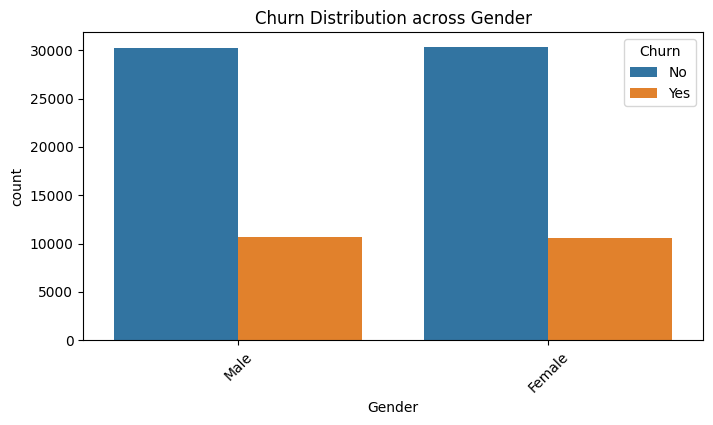

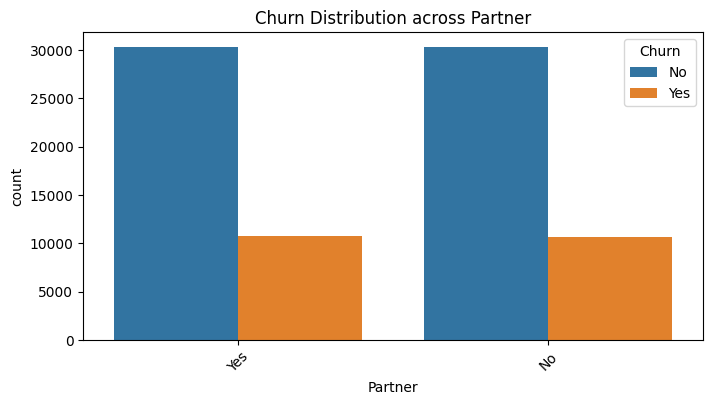

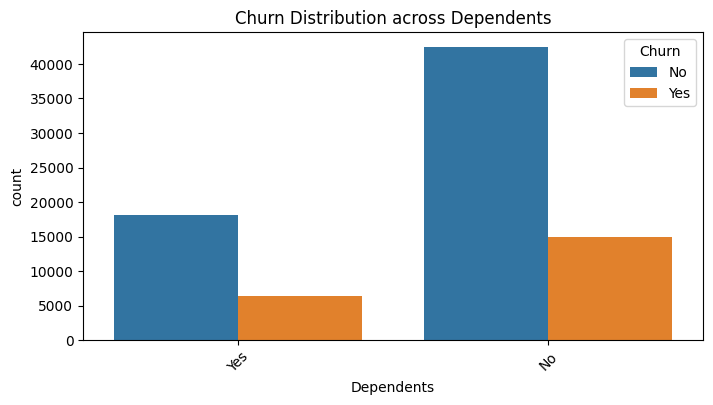

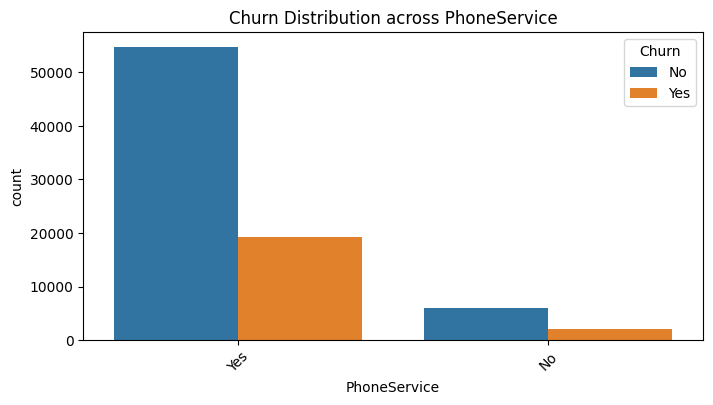

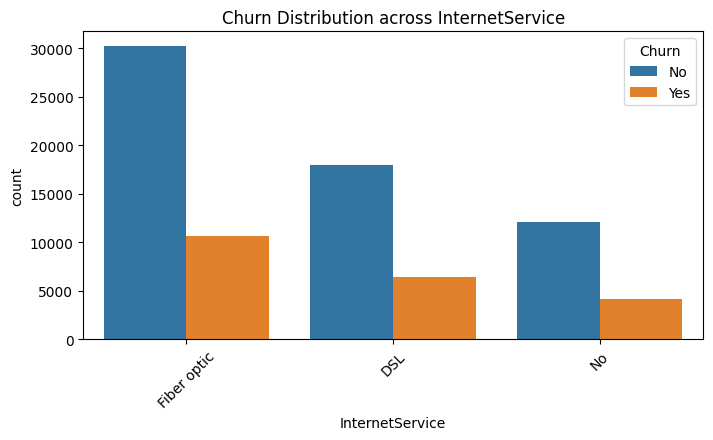

In [16]:
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f'Churn Distribution across {col}')
    plt.xticks(rotation=45)
    plt.show()

- Gender & having a partner don't have any significant effect on customer churn.
- Customers with dependents are less likely to leave than those without dependents.
- Customers with phone service are more likely to leave than those without phone service.
- Customers with 'Fiber optic' internet service are more likely to leave than those with 'DSL' or no internet service.

## Task 2 : Feature Engineering

We will create following 3 new columns: 

- ‘ServiceCount’, counting no. of services (Phone, Internet) subscribed by a customer. This will help us in further estimating the missing values of 'TotalCharges' based on it.

- 'AvgMonthlySpend', to find the average monthly revenue for each customer by dividing 'TotalCharges' by 'Tenure'. This will help us better compare the revenue generated by each customer on a monthly basis.

- 'TenureYears' to convert tenure in months to years. It will help in accurately imputing missing values in 'totalCharges'. By replacing a null value in TotalCharges with the median of its specific 'TenureYears' range. We can also easily compare how different customer groups behave instead of analyzing each customer's monthly data individually.

In [17]:
df['ServiceCount'] = df[['PhoneService', 'InternetService']].notnull().sum(axis=1)

In [18]:
# Fill NaN values in the grouping columns first
df['Tenure'].fillna(0, inplace=True)
df['TenureYears'] = np.floor(df['Tenure'] / 12).astype(int)

C:\Users\palla\AppData\Local\Temp\ipykernel_34796\1925461634.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Tenure'].fillna(0, inplace=True)


In [19]:
# Calculate the median of TotalCharges for each combination of TenureGroup and ServiceCount
median_charges = df.groupby(['TenureYears', 'ServiceCount'])['TotalCharges'].median().reset_index()

# Iterate and impute missing 'TotalCharges' values
for index, row in df[df['TotalCharges'].isnull()].iterrows():
    tenure_group = row['TenureYears']
    service_count = row['ServiceCount']

    # Find the corresponding median value from the calculated medians
    median_value = median_charges[(median_charges['TenureYears'] == tenure_group) &
                                 (median_charges['ServiceCount'] == service_count)]['TotalCharges'].values
    
    # Fill the NaN if a median value exists
    if len(median_value) > 0:
        df.loc[index, 'TotalCharges'] = median_value[0]

In [20]:
# For records with a 0 tenure, the AvgMonthlySpend will be set to NaN.
df['AvgMonthlySpend'] = np.where(df['Tenure'] > 0, df['TotalCharges'] / df['Tenure'], np.nan)

In [21]:
df.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,InternetService,MonthlyCharges,TotalCharges,Churn,Timestamp,ServiceCount,TenureYears,AvgMonthlySpend
0,CUST000001,Male,0.0,Yes,Yes,26.0,Yes,Fiber optic,70.32,1994.70,No,2021-10-26,2,2,76.719231
1,CUST000002,Female,0.0,No,No,0.0,Yes,Fiber optic,47.88,2161.36,Yes,2022-04-03,2,0,NaN
2,CUST000003,Male,0.0,No,Yes,0.0,Yes,NaN,99.91,4224.95,Yes,2021-05-03,1,0,NaN
3,CUST000004,Male,NaN,No,No,44.0,Yes,DSL,29.44,1340.09,No,2021-08-18,2,3,30.456591
4,CUST000005,NaN,0.0,No,Yes,29.0,NaN,Fiber optic,78.82,2280.05,No,2022-02-17,1,2,78.622414


## Task 3 : Building the End-to-End Pipeline

### 3.1. Define Preprocessing Steps

In [22]:
df.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,InternetService,MonthlyCharges,TotalCharges,Churn,Timestamp,ServiceCount,TenureYears,AvgMonthlySpend
0,CUST000001,Male,0.0,Yes,Yes,26.0,Yes,Fiber optic,70.32,1994.70,No,2021-10-26,2,2,76.719231
1,CUST000002,Female,0.0,No,No,0.0,Yes,Fiber optic,47.88,2161.36,Yes,2022-04-03,2,0,NaN
2,CUST000003,Male,0.0,No,Yes,0.0,Yes,NaN,99.91,4224.95,Yes,2021-05-03,1,0,NaN
3,CUST000004,Male,NaN,No,No,44.0,Yes,DSL,29.44,1340.09,No,2021-08-18,2,3,30.456591
4,CUST000005,NaN,0.0,No,Yes,29.0,NaN,Fiber optic,78.82,2280.05,No,2022-02-17,1,2,78.622414


On the basis of earlier data analysis and the new columns made, we will drop the following columns:
- Gender
- Partner
- Tenure
- PhoneService
- TotalCharges
- Timestamp

In [23]:
columns_to_drop = ['Gender', 'Partner', 'Tenure', 'PhoneService', 'TotalCharges', 'Timestamp']

# Drop the columns from the DataFrame
df.drop(columns=columns_to_drop, inplace=True)

In [24]:
df.head()

,CustomerID,SeniorCitizen,Dependents,InternetService,MonthlyCharges,Churn,ServiceCount,TenureYears,AvgMonthlySpend
0,CUST000001,0.0,Yes,Fiber optic,70.32,No,2,2,76.719231
1,CUST000002,0.0,No,Fiber optic,47.88,Yes,2,0,NaN
2,CUST000003,0.0,Yes,NaN,99.91,Yes,1,0,NaN
3,CUST000004,NaN,No,DSL,29.44,No,2,3,30.456591
4,CUST000005,0.0,Yes,Fiber optic,78.82,No,1,2,78.622414


In [25]:

numeric_features = ['MonthlyCharges', 'ServiceCount', 'TenureYears', 'AvgMonthlySpend']
categorical_features = ['Dependents', 'InternetService', 'SeniorCitizen']
# Although SeniorCitizen is a binary categorical feature, Treating it as a categorical feature and applying a OneHotEncoder ensures the model understands it as a distinct group rather than a numerical value.

# --- Create Preprocessing Pipelines for each data type ---
numeric_pipeline = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
categorical_pipeline = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

# --- Combine all preprocessors into a ColumnTransformer ---
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

NameError: name 'SimpleImputer' is not defined

### 3.2. Integrate with Pipeline

In [ ]:

target = 'Churn'
y = df[target]
X = df.drop(columns=[target, 'CustomerID'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# --- Train the entire pipeline on the training data ---
print("Training the pipeline...")
model_pipeline.fit(X_train, y_train)
print("Pipeline training complete!")

Training the pipeline...
Pipeline training complete!


## Task 4 : Model Selection and Hyperparameter Tuning

### 4.1. Choose Models 

We'll use  following 3 models for predicting cutomer churn
- Logistic Regression
    - Simple to implement and easy to interpret.
    - Helps understand how each factor influences churn.

- Random Forest Classifier
    - Works well with both numeric and categorical data without heavy preprocessing.
    - Captures complex patterns and relationships in the data.

- Gradient Boosting Classifier (XGBoost or similar)
    - Provides high accuracy by learning from previous mistakes.
    - Handles missing data and reduces overfitting, making it reliable for real-world datasets.

These models are suitable for churn prediction because customer behavior is influenced by many factors, and these models can capture both simple and complex relationships.

In [ ]:

grids = {
    "LR": (
        LogisticRegression(random_state=42, solver='liblinear'),
        {
            "reg__C": [0.1, 1, 10],
            "reg__penalty": ["l1", "l2"]
        }
    ),
    "RF": (
        RandomForestClassifier(random_state=42, class_weight='balanced'),
        {
            "reg__n_estimators": [100, 200],
            "reg__max_depth": [None, 10, 20]
        }
    ),
    "GB": (
        GradientBoostingClassifier(random_state=42),
        {
            "reg__n_estimators": [100, 200],
            "reg__learning_rate": [0.05, 0.1],
            "reg__max_depth": [3, 5]
        }
    )
}


In [ ]:

searches = {}

for name, (mdl, params) in grids.items():
    pipe = Pipeline([
        ("prep", preprocessor),  
        ("reg", mdl)              
    ])
    
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=params,
        cv=3,
        scoring="f1_weighted",   # appropriate for imbalanced classification problems
        n_jobs=-1,
        verbose=1
    )
    
    gs.fit(X_train, y_train)
    
    # Store the search result
    searches[name] = gs
    
    # Print the best score and best parameters
    print(f"{name} → Best F1 Weighted Score: {gs.best_score_:.4f}")
    print("   Best Parameters:", gs.best_params_, "\n")


Fitting 3 folds for each of 6 candidates, totalling 18 fits
LR → Best F1 Weighted Score: 0.6295
   Best Parameters: {'reg__C': 0.1, 'reg__penalty': 'l1'} 

Fitting 3 folds for each of 6 candidates, totalling 18 fits
RF → Best F1 Weighted Score: 0.6302
   Best Parameters: {'reg__max_depth': None, 'reg__n_estimators': 200} 

Fitting 3 folds for each of 8 candidates, totalling 24 fits
GB → Best F1 Weighted Score: 0.6303
   Best Parameters: {'reg__learning_rate': 0.1, 'reg__max_depth': 5, 'reg__n_estimators': 200} 



### 4.2. Hyperparameter Tuning

In [ ]:

# Pick the best model based on the highest F1 Weighted score
best_name, best_gs = max(searches.items(), key=lambda kv: kv[1].best_score_)
best_model = best_gs.best_estimator_

# Predict on test data
y_pred = best_model.predict(X_test)

# For ROC AUC, we need prediction probabilities
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probability for class '1'

# Report classification metrics
print("Best Model:", best_name)
print(f"F1 Score    : {f1_score(y_test, y_pred, average='weighted'):.3f}")
print(f"ROC AUC     : {roc_auc_score(y_test, y_proba):.3f}")


Best Model: GB
F1 Score    : 0.627
ROC AUC     : 0.504


## Task 5 : Handling Class Imbalance

In [ ]:
df.Churn.value_counts()

Churn
No     73956
Yes    26044
Name: count, dtype: int64

Only 1/4th of values are 'No' in 'Churn' column, indicating class imbalance.

### 5.1. Implement a Strategy

We will do Resampling using SMOTE, which is supported by Gradient Boosting Classifier.

In [ ]:

pipeline_smote = Pipeline([
    ('preprocessing', preprocessor),   # your preprocessing steps
    ('smote', SMOTE(sampling_strategy=0.8, k_neighbors=40, random_state=42)), # oversampling the minority class
    ('classifier', GradientBoostingClassifier(random_state=42))
])
# Evaluate using cross-validation
scores_smote = cross_val_score(pipeline_smote, X_train, y_train, cv=5, scoring='f1_weighted')

print("F1 Weighted Score with SMOTE:", scores_smote.mean())

F1 Weighted Score with SMOTE: 0.6350968075198363


### 5.2. Compare and Conclude

In [ ]:
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1_weighted')
print("F1 Weighted Score without imbalance handling:", scores.mean())

F1 Weighted Score without imbalance handling: 0.6295546510149457


We can observe that our model's performance has improved on applying class imbalance statergy. SMOTE (Synthetic Minority Oversampling Technique) creates synthetic samples for the minority class so that both classes are balanced during training.

## Task 6 : Final Evaluation and Interpretation

### 6.1. Test Set Evaluation

In [ ]:

pipeline_smote.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline_smote.predict(X_test)
y_proba = pipeline_smote.predict_proba(X_test)[:, 1]  # For ROC AUC

### 6.2. Metrics Report

Precision: 0.6118284144467213
Recall   : 0.72605
F1 Score : 0.6310874389926495
ROC AUC  : 0.5044778906884344

Classification Report:

              precision    recall  f1-score   support

          No       0.74      0.98      0.84     14753
         Yes       0.26      0.02      0.04      5247

    accuracy                           0.73     20000
   macro avg       0.50      0.50      0.44     20000
weighted avg       0.61      0.73      0.63     20000



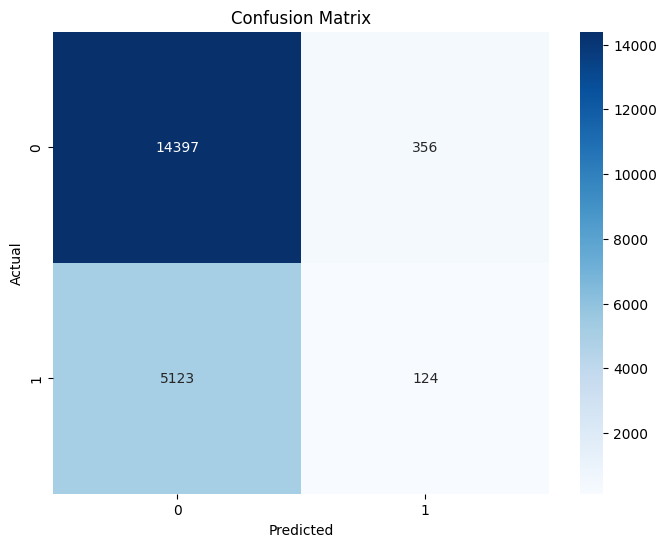

In [ ]:

print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score :", f1_score(y_test, y_pred, average='weighted'))
print("ROC AUC  :", roc_auc_score(y_test, y_proba))

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### 6.3. Interpretation

In above confusion matrix,
- False Positive (FP) means predicting a customer would churn, but they stayed.

- False Negative (FN) means predicting a customer would stay, but they churned. Here, his 

False Negatives are worse because in case of FP, business might waste resources trying to retain them. But in case of FN, business missed an opportunity to prevent losing a customer. Here, they lost both revenue and reputation. The situation could have been avoided till a great extent if necessary retention campaigns had been applied in time.

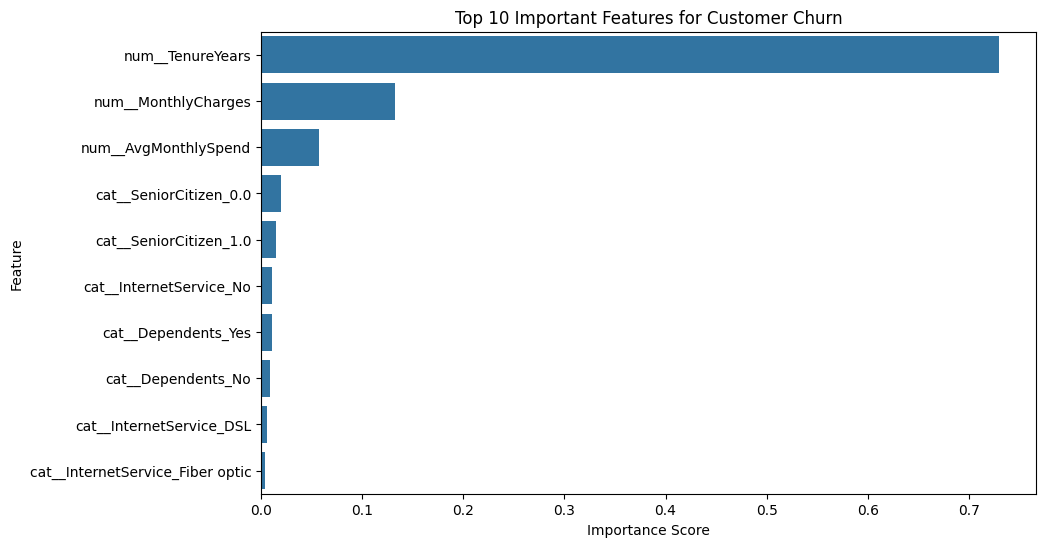

In [ ]:
clf = pipeline_smote.named_steps['classifier']
importances = clf.feature_importances_
feature_names = preprocessor.get_feature_names_out()
indices = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=feature_names[indices])
plt.title("Top 10 Important Features for Customer Churn")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

From above bar plot, we can observe that following are the main drivers of customer churn:
- High tenure : longer-tenured customers are less likely to churn.
- Monthly charges : higher charges may increase churn risk.
- Age group : Senior citizens are less likely to churn than young ones.